# AKARI-SEP master catalogue
## Checks and diagnostics

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
017bb1e (Mon Jun 18 14:58:59 2018 +0100) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
plt.style.use('ggplot')

import locale
#locale.setlocale(locale.LC_ALL, 'en_GB')

import os
import time
import itertools

from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy import units as u
from astropy import visualization as vis
import numpy as np
from matplotlib_venn import venn3, venn2

from herschelhelp_internal.masterlist import nb_compare_mags, nb_ccplots, nb_histograms, find_last_ml_suffix, quick_checks

/opt/pyenv/versions/3.7.2/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/pyenv/versions/3.7.2/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/opt/pyenv/versions/3.7.2/lib/python3.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = find_last_ml_suffix()
#SUFFIX = "20171016"

master_catalogue_filename = "master_catalogue_akari-sep_dr2_{}.fits".format(SUFFIX)
master_catalogue = Table.read("{}/{}".format(OUT_DIR, master_catalogue_filename))

print("Diagnostics done using: {}".format(master_catalogue_filename))

Diagnostics done using: master_catalogue_akari-sep_dr2_20210702.fits


# 0 - Quick checks

In [4]:
quick_checks(master_catalogue).show_in_notebook()

Table shows only problematic columns.


idx,Column,All nan,#Measurements,#Zeros,#Negative,Minimum value
0,ferr_wise_w1,False,146493,0,116,-99000.0
1,ferr_wise_w2,False,146493,0,22638,-99000.0
2,ferr_wise_w3,False,146493,0,117158,-99000.0
3,ferr_wise_w4,False,146493,0,139053,-99000.0
4,merr_wise_w1,False,146493,0,116,-28220.159114034715
5,merr_wise_w2,False,146493,0,22638,-15522.428822295375
6,merr_wise_w3,False,146493,0,117158,-1211.6008249077497
7,merr_wise_w4,False,146493,0,139053,-162.39008018604738


## I - Summary of wavelength domains

In [5]:
flag_obs = master_catalogue['flag_optnir_obs']
flag_det = master_catalogue['flag_optnir_det']

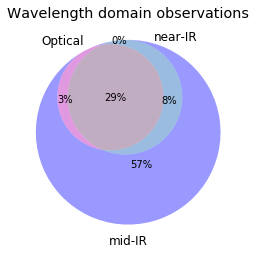

In [6]:
venn3(
    [
        np.sum(flag_obs == 4),
        np.sum(flag_obs == 2),
        np.sum(flag_obs == 6),
        np.sum(flag_obs == 1),
        np.sum(flag_obs == 5),
        np.sum(flag_obs == 3),
        np.sum(flag_obs == 7)
    ],
    set_labels=('Optical', 'near-IR', 'mid-IR'),
    subset_label_formatter=lambda x: "{}%".format(int(100*x/len(flag_obs)))
)
plt.title("Wavelength domain observations");

/opt/pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: This method will be removed in a future version of Python. Use 'locale.format_string()' instead.
/opt/pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: This method will be removed in a future version of Python. Use 'locale.format_string()' instead.


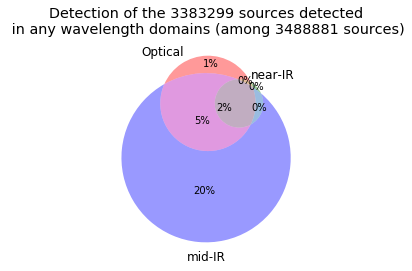

In [7]:

venn3(
    [
        np.sum(flag_det[flag_obs == 7] == 4),
        np.sum(flag_det[flag_obs == 7] == 2),
        np.sum(flag_det[flag_obs == 7] == 6),
        np.sum(flag_det[flag_obs == 7] == 1),
        np.sum(flag_det[flag_obs == 7] == 5),
        np.sum(flag_det[flag_obs == 7] == 3),
        np.sum(flag_det[flag_obs == 7] == 7)
    ],
    set_labels=('Optical', 'near-IR', 'mid-IR'),
    subset_label_formatter=lambda x: "{}%".format(int(100*x/np.sum(flag_det != 0)))
)
plt.title("Detection of the {} sources detected\n in any wavelength domains "
          "(among {} sources)".format(
              locale.format('%d', np.sum(flag_det != 0), grouping=True),
              locale.format('%d', len(flag_det), grouping=True)));

## II - Comparing magnitudes in similar filters

Om AKARI-SEP there are no bands with multiple observations. It is still instructive to plot magnitude histograms to give a measure of depth.

In [8]:
u_bands = []
g_bands = ["DECam g"]
r_bands = ["DECam r"]
i_bands = ["DECam i"]
z_bands = ["DECam z"]
y_bands = ["DECam y"]
j_bands = [           "VISTA j"]
h_bands = [           "VISTA h"]
k_bands = [           "VISTA ks"]

### II.a - Comparing depths

We compare the histograms of the total aperture magnitudes of similar bands. This revealed that there were no VISTA y band measurements in VHS so we removed that column.

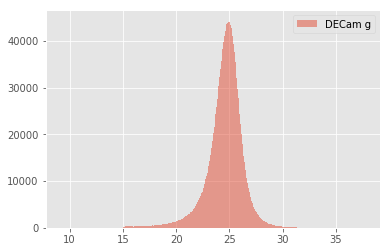

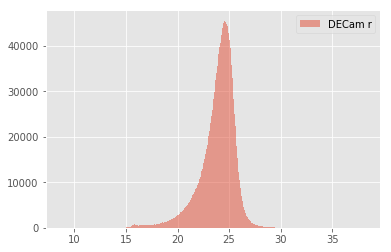

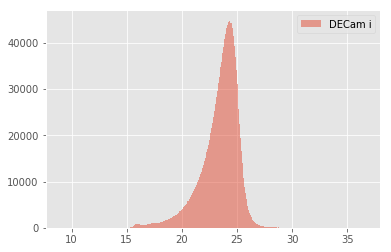

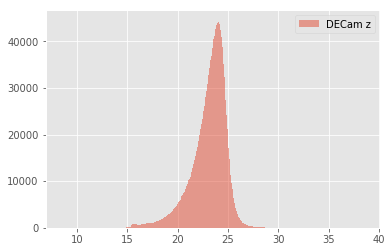

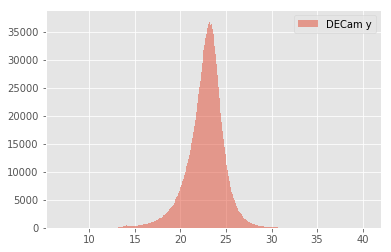

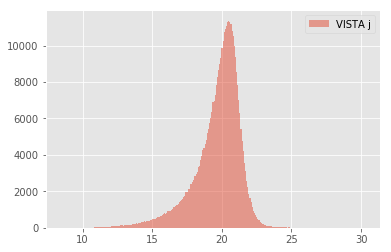

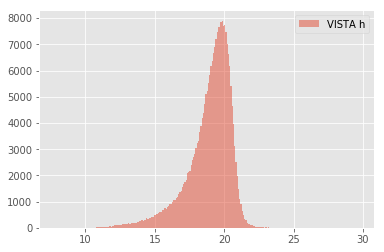

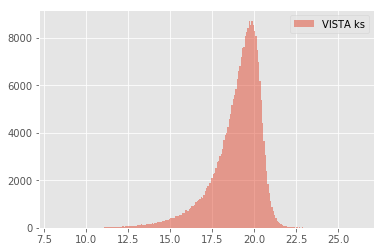

In [9]:
for bands in [g_bands, r_bands, i_bands, z_bands, y_bands, j_bands, h_bands, k_bands]:
    colnames = ["m_{}".format(band.replace(" ", "_").lower()) for band in bands]
    nb_histograms(master_catalogue, colnames, bands)

## III - Comparing magnitudes to reference bands

Cross-match the master list to 2MASS to compare its magnitudes to 2MASS ones.

In [10]:
master_catalogue_coords = SkyCoord(master_catalogue['ra'], master_catalogue['dec'])

### III.b - Comparing J and K bands to 2MASS

The catalogue is cross-matched to 2MASS-PSC withing 0.2 arcsecond. We compare the UKIDSS total J and K magnitudes to those from 2MASS.

The 2MASS magnitudes are “*Vega-like*” and we have to convert them to AB magnitudes using the zero points provided on [this page](http://www.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4a.html):

| Band | Fν - 0 mag (Jy) |
|------|-----------------|
| J    | 1594            |
| H    | 1024            |
| Ks   | 666.7           |

In addition, UKIDSS uses a K band whereas 2MASS uses a Ks (“short”) band, [this page](http://www.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4b.html) give a correction to convert the K band in a Ks band with the formula:

$$K_{s(2MASS)} = K_{UKIRT} + 0.003 + 0.004 * (J−K)_{UKIRT}$$

In [11]:
# The AB zero point is 3631 Jy
j_2mass_to_ab = 2.5 * np.log10(3631/1595)
k_2mass_to_ab = 2.5 * np.log10(3631/666.7)

In [12]:
twomass = Table.read("../../dmu0/dmu0_2MASS-point-sources/data/2MASS-PSC_AKARI-SEP.fits")
twomass_coords = SkyCoord(twomass['raj2000'], twomass['dej2000'])

idx, d2d, _ = twomass_coords.match_to_catalog_sky(master_catalogue_coords)
mask = (d2d < 0.2 * u.arcsec)

twomass = twomass[mask]
ml_twomass_idx = idx[mask]

VISTA J (total) - 2MASS J:
- Median: 0.03
- Median Absolute Deviation: 0.05
- 1% percentile: -1.0367844232084094
- 99% percentile: 0.6363114506624397


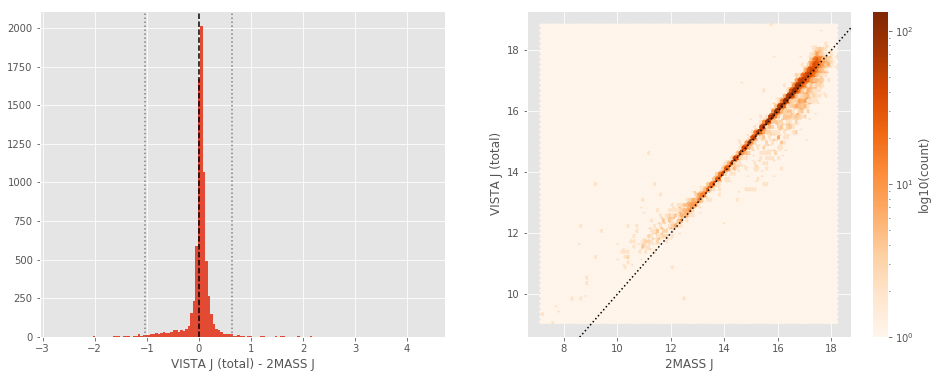

In [13]:
nb_compare_mags(twomass['jmag'] + j_2mass_to_ab, master_catalogue['m_vista_j'][ml_twomass_idx],
                labels=("2MASS J", "VISTA J (total)"))

VISTA Ks (total) - 2MASS Ks:
- Median: 0.04
- Median Absolute Deviation: 0.08
- 1% percentile: -1.0019945516069917
- 99% percentile: 0.9395000327435948


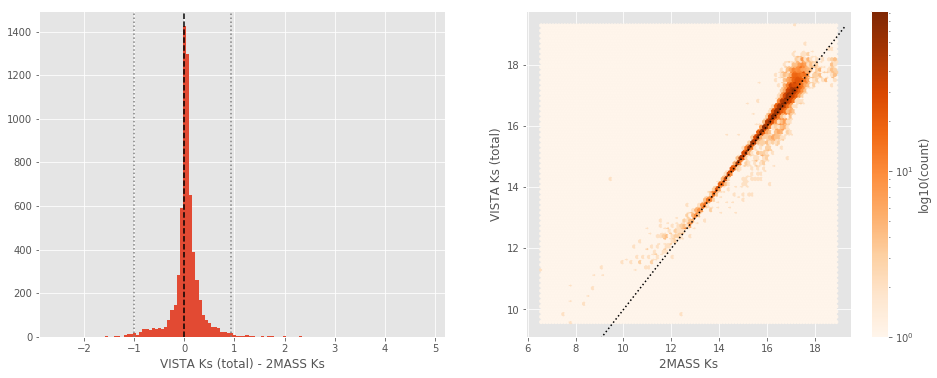

In [14]:
nb_compare_mags(twomass['kmag'] + k_2mass_to_ab, master_catalogue['m_vista_ks'][ml_twomass_idx],
                labels=("2MASS Ks", "VISTA Ks (total)"))

## Keeping only sources with good signal to noise ratio

From here, we are only comparing sources with a signal to noise ratio above 3, i.e. roughly we a magnitude error below 0.3.

*To make it easier, we are setting to NaN in the catalogue the magnitudes associated with an error above 0.3 so we can't use these magnitudes after the next cell.*

In [15]:
for error_column in [_ for _ in master_catalogue.colnames if _.startswith('merr_')]:
    column = error_column.replace("merr", "m")
    keep_mask = np.isfinite(master_catalogue[error_column])
    keep_mask[keep_mask] &= master_catalogue[keep_mask][error_column] <= 0.3
    master_catalogue[column][~keep_mask] = np.nan

## IV - Comparing aperture magnitudes to total ones.

Number of source used: 190573 / 3488881 (5.46%)


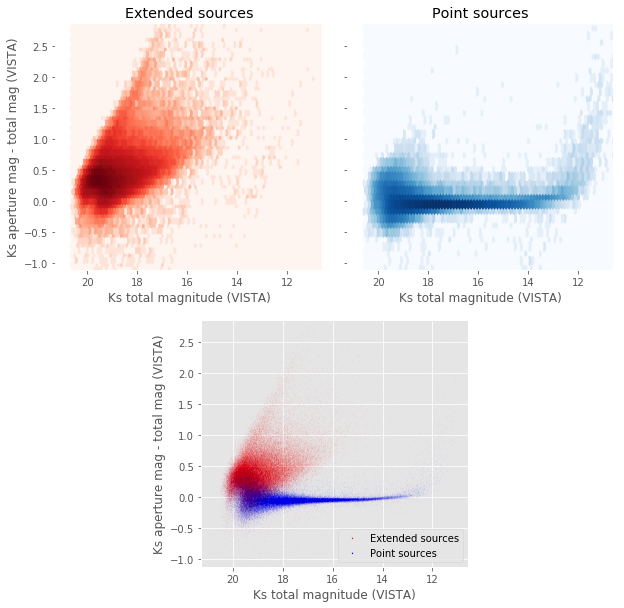

In [16]:
nb_ccplots(
    master_catalogue['m_vista_ks'],
    master_catalogue['m_ap_vista_ks'] - master_catalogue['m_vista_ks'],
    "Ks total magnitude (VISTA)", "Ks aperture mag - total mag (VISTA)",
    master_catalogue["stellarity"],
    invert_x=True
)

## V - Color-color and magnitude-color plots

Number of source used: 36774 / 3488881 (1.05%)


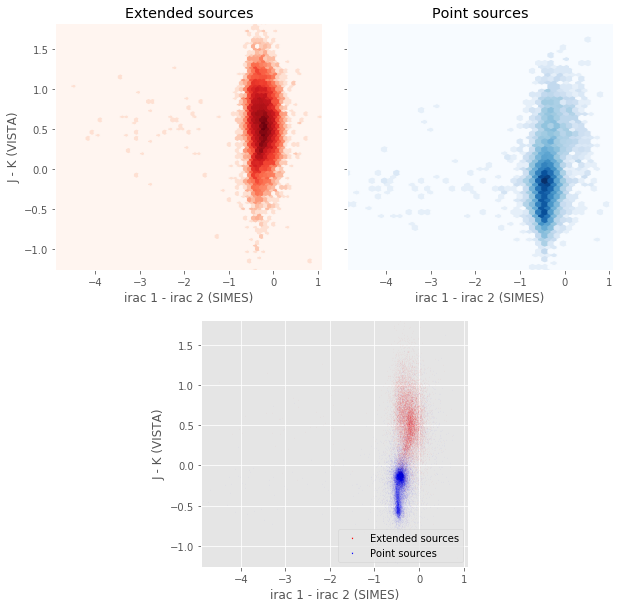

In [17]:
nb_ccplots(
    master_catalogue['m_irac_i1'] - master_catalogue['m_irac_i2'],
    master_catalogue['m_vista_j'] - master_catalogue['m_vista_ks'],
    "irac 1 - irac 2 (SIMES)", "J - K (VISTA)",
    master_catalogue["stellarity"]
)